In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

import pandas as pd

import sys
print(sys.version)

import mmml

# import pyscf

3.12.0 (main, Oct  3 2023, 01:27:23) [Clang 17.0.1 ]


In [2]:
!which python
# ! uv pip install pyscf

/pchem-data/meuwly/boittier/home/mmml/.venv/bin/python


In [114]:
import numpy as np
import cupy
from gpu4pyscf.scf import hf, cphf, _response_functions
from gpu4pyscf.lib.cupy_helper import contract

def gen_vind(mf, mo_coeff, mo_occ):
    """get the induced potential. This is the same as contract the mo1 with the kernel.

    Args:
        mf: mean field object
        mo_coeff (numpy.array): mo coefficients
        mo_occ (numpy.array): mo_coefficients

    Returns:
        fx (function): a function to calculate the induced potential with the input as the mo1.
    """
    nao, nmo = mo_coeff.shape
    mocc = mo_coeff[:, mo_occ > 0]
    mvir = mo_coeff[:, mo_occ == 0]
    nocc = mocc.shape[1]
    nvir = nmo - nocc
    vresp = mf.gen_response(mo_coeff, mo_occ, hermi=1)

    def fx(mo1):
        mo1 = mo1.reshape(-1, nvir, nocc)  # * the saving pattern
        mo1_mo_real = contract('nai,ua->nui', mo1, mvir)
        dm1 = 2*contract('nui,vi->nuv', mo1_mo_real, mocc.conj())
        dm1+= dm1.transpose(0,2,1)

        v1 = vresp(dm1)  # (nset, nao, nao)
        tmp = contract('nuv,vi->nui', v1, mocc)
        v1vo = contract('nui,ua->nai', tmp, mvir.conj())

        return v1vo
    return fx


def eval_polarizability(mf):
    """main function to calculate the polarizability

    Args:
        mf: mean field object

    Returns:
        polarizability (numpy.array): polarizability in au
    """
    assert isinstance(mf, hf.RHF), "Unrestricted mf object is not supported."

    polarizability = np.empty((3, 3))

    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    mo_energy = mf.mo_energy
    mo_coeff = mo_coeff #cupy.array(mo_coeff)
    mo_occ = mo_occ #cupy.array(mo_occ)
    mo_energy = mo_energy
    fx = gen_vind(mf, mo_coeff, mo_occ)
    mocc = mo_coeff[:, mo_occ > 0]
    mvir = mo_coeff[:, mo_occ == 0]

    with mf.mol.with_common_orig((0, 0, 0)):
        h1 = mf.mol.intor('int1e_r')
        h1 = cupy.array(h1)
    for idirect in range(3):
        print(h1[idirect].shape)
        print(h1[idirect].sum(axis=1))
        h1ai = -mvir.T.conj()@h1[idirect]@mocc
        mo1 = cphf.solve(fx, mo_energy, mo_occ, h1ai,  max_cycle=20, tol=1e-10)[0]
        for jdirect in range(idirect, 3):
            p10 = np.trace(mo1.conj().T@mvir.conj().T@h1[jdirect]@mocc)*2
            p01 = np.trace(mocc.conj().T@h1[jdirect]@mvir@mo1)*2
            polarizability[idirect, jdirect] = p10+p01
    polarizability[1, 0] = polarizability[0, 1]
    polarizability[2, 0] = polarizability[0, 2]
    polarizability[2, 1] = polarizability[1, 2]

    return polarizability, h1


In [115]:
from mmml.pyscf4gpuInterface.calcs import setup_mol

In [505]:
mol_str = """O     -2.217302    2.805476    2.146856 
H     -2.260473    3.658861    2.578259    
H     -2.256339    3.006951    1.211915  """

In [907]:
mf, mol = setup_mol(mol_str, "def2-tzvp", "PBE0", 0, 0)

overwrite output file: ./pyscf.log


In [908]:
?mf.get_veff

Signature: mf.get_veff(mol=None, dm=None, dm_last=None, vhf_last=0, hermi=1)
Docstring: effective potential
File:      ~/mmml/.venv/lib/python3.12/site-packages/gpu4pyscf/df/df_jk.py
Type:      method

In [909]:
dir(mf)
# mf.mo_energy.sum()

['CasidaTDDFT',
 'DIIS',
 'Gradients',
 'Hessian',
 'PCM',
 'SMD',
 'TDA',
 'TDDFT',
 'TDDFTNoHybrid',
 'TDHF',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__name_mixin__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_eigh',
 '_eri',
 '_finalize',
 '_is_mem_enough',
 '_keys',
 '_numint',
 '_opt_gpu',
 'analyze',
 'apply',
 'as_scanner',
 'auxbasis',
 'build',
 'callback',
 'canonicalize',
 'check_convergence',
 'check_sanity',
 'chkfile',
 'conv_check',
 'conv_tol',
 'conv_tol_cpscf',
 'conv_tol_grad',
 'converged',
 'copy',
 'cphf_grids',
 'damp',
 'define_xc_',
 'density_fit',
 'device',
 'diis',
 'diis_damp',
 'diis_file',
 'diis_space',
 'diis_space_rollb

In [910]:
mf.kernel()

-76.3773370272375

In [911]:
mf.dip_moment(unit="") 

array([-0.05727563,  0.7349374 , -0.35082401])

In [650]:
from pyscf import gto, scf, tools
dm_init_guess = [None]
def apply_field(E, mol):
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
      + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    mf = scf.RHF(mol)
    mf.get_hcore = lambda *args: h
    mf.scf(dm_init_guess[0])
    dm_init_guess[0] = mf.make_rdm1()
    e = mf.kernel()    
    dip_m = mf.dip_moment()
    return e, dip_m
    # mo = mf.mo_coeff #[:,mo_id]
    # print(mf)
    # # if mo[23] < -1e-5:  # To ensure that all MOs have same phase
    #     # mo *= -1
    # return mo

In [657]:
t0, dipole_m0 = apply_field(np.zeros(3), mol)
# np.linalg.norm(t0)
# np.sum(t0)
t0, dipole_m0

(-76.05904280717294, array([-0.15137997,  1.94244428, -0.92722976]))

In [662]:
dipole_m0[1]/dipole_m0[0], dipole_m0[2]/dipole_m0[0], dipole_m0[1]/dipole_m0[2]

(-12.831580771483527, 6.125181395716535, -2.0948899212122787)

In [792]:
# for i in range(np.zeros((3,3))
mol.intor('cint1e_r_sph', comp=3).shape

(3, 43, 43)

In [1133]:
dE = 10**-4
out_p = []
out_alpha = []
for E in np.eye(3).reshape(3, 3)*dE :
    
    
    def apply_field(E):
        dm_init_guess = [None]
        # mf, mol = setup_mol(mol_str, "def2-tzvp", "PBE0", 0, 0)
        mol = pyscf.M(
        atom=mol_str,                         # water molecule
        basis="def2-tzvp",                # basis set
        spin=0,
        charge=0,
        unit="B",
        # output=log_file,              # save log file
        # verbose=verbose                          # control the level of print info
        )
        mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
        h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
          + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
        mf = rks.RKS(mol, xc="PBE0").density_fit()  
        mf.get_hcore = lambda *args: h
        mf.scf(dm_init_guess[0])
        # dm_init_guess[0] = mf.make_rdm1()
        e = mf.kernel()  
        mf.get_veff()
        print(mf.scf_summary)
        e = mf.scf_summary["coul"]
        dip_m = mf.dip_moment(unit="AU")
        return e, dip_m
           
    t0, dipole_m0 = apply_field(np.zeros(3))
    mol = pyscf.M(
            atom=mol_str,                         # water molecule
            basis="def2-tzvp",                # basis set
            spin=0,
            charge=0,
            unit="B",
            # output=log_file,              # save log file
            # verbose=verbose                          # control the level of print info
            )
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
      + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    mf = rks.RKS(mol, xc="PBE0").density_fit()  
    t1, dipole_m1 = apply_field(E)
    mol = pyscf.M(
            atom=mol_str,                         # water molecule
            basis="def2-tzvp",                # basis set
            spin=0,
            charge=0,
            unit="B",
            # output=log_file,              # save log file
            # verbose=verbose                          # control the level of print info
            )
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
      + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    mf = rks.RKS(mol, xc="PBE0").density_fit()  
    t2, dipole_m2 = apply_field(-1*E)
    dplus = (t0 - t1)
    dminus = (t0 - t2)
    dm_dE1 = (dipole_m0 - dipole_m1)
    dm_dE2 = (dipole_m0 - dipole_m2)

    out_alpha.append((dm_dE1 - dm_dE2))
    out_p.append((dplus - dminus))

converged SCF energy = -74.9278282380878
converged SCF energy = -74.9278282380884
{'e1': -134.9877551282411, 'coul': 52.68148134756547, 'exc': -9.997494947743906, 'nuc': 17.375940490331146}
Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60122, -0.28700
converged SCF energy = -74.9300490979195
converged SCF energy = -74.9300490979201
{'e1': -134.98998248426201, 'coul': 52.6814887977379, 'exc': -9.997495901727186, 'nuc': 17.375940490331146}
Dipole moment(X, Y, Z, A.U.): -0.04640,  0.60123, -0.28700
converged SCF energy = -74.9256074232754
converged SCF energy = -74.925607423276
{'e1': -134.98552753031598, 'coul': 52.68147357432596, 'exc': -9.997493957617156, 'nuc': 17.375940490331146}
Dipole moment(X, Y, Z, A.U.): -0.04730,  0.60122, -0.28699
converged SCF energy = -74.9278282380878
converged SCF energy = -74.9278282380884
{'e1': -134.9877551282411, 'coul': 52.68148134756547, 'exc': -9.997494947743906, 'nuc': 17.375940490331146}
Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60122, -0.28700
conv

In [ ]:
# from functools import reduce
# from pyscf.hessian import thermo
# import numpy as np
# import cupy
# from pyscf.data import elements, nist
# from scipy.constants import physical_constants
# from gpu4pyscf.lib import logger
# from gpu4pyscf.lib.cupy_helper import contract
# from gpu4pyscf.scf.hf import RHF

# LINDEP_THRESHOLD = 1e-7


# def maxwell_eval_ir_freq_intensity(E, mol):
#     '''Main driver of infrared spectra intensity

#     Args:
#         mf: mean field object
#         hessian_obj: hessian object

#     Returns:
#         frequency mode: in cm^-1
#         infrared spectra intensity: in km/mol
#     '''

#     dm_init_guess = [None]
#     mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
#     h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
#       + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
#     mf = rks.RKS(mol, xc="PBE0").density_fit()  
#     mf.get_hcore = lambda *args: h
#     mf.scf(dm_init_guess[0])
#     e = mf.kernel()  
#     mf.get_veff()
#     dip_m = mf.dip_moment(unit="AU")
#     polar = polarizability.eval_polarizability(mf)
#     summary = mf.scf_summary

#     g = mf.nuc_grad_method()
#     g_dft = g.kernel()
#     summary['F'] = -g_dft
    
#     summary.update({"Ef": E, "D": dip_m, "E": e })
#     # Compute Hessian
#     h = mf.Hessian()
#     h.auxbasis_response = 2                # 0: no aux contribution, 1: some contributions, 2: all
#     mf.cphf_grids.atom_grid = (50,194) # customize grids for solving CPSCF equation, SG1 by default
#     h_dft = h.kernel()
#     hessian_obj = h
#     summary['H'] = h_dft

    
#     log = logger.new_logger(hessian_obj, mf.mol.verbose)
#     assert isinstance(mf, RHF)
#     hessian = hessian_obj.kernel()
#     hartree_kj = nist.HARTREE2J*1e3
#     unit2cm = ((hartree_kj * nist.AVOGADRO)**.5 / (nist.BOHR*1e-10)
#                / (2*np.pi*nist.LIGHT_SPEED_SI) * 1e-2)
#     natm = mf.mol.natm
#     nao = mf.mol.nao
#     dm0 = mf.make_rdm1()

#     atom_charges = mf.mol.atom_charges()
#     mass = cupy.array([elements.MASSES[atom_charges[i]] for i in range(natm)])
#     # hessian_mass = contract('ijkl,i,j->ijkl', hessian,
#     #                          1/cupy.sqrt(mass), 1/cupy.sqrt(mass))
#     hessian_mass = contract('ijkl,i->ijkl', cupy.array(hessian), 1/cupy.sqrt(mass))
#     hessian_mass = contract('ijkl,j->ijkl', hessian_mass, 1/cupy.sqrt(mass))

#     TR = thermo._get_TR(mass.get(), mf.mol.atom_coords())
#     TRspace = []
#     TRspace.append(TR[:3])

#     rot_const = thermo.rotation_const(mass.get(), mf.mol.atom_coords())
#     rotor_type = thermo._get_rotor_type(rot_const)
#     if rotor_type == 'ATOM':
#         pass
#     elif rotor_type == 'LINEAR':  # linear molecule
#         TRspace.append(TR[3:5])
#     else:
#         TRspace.append(TR[3:])

#     if TRspace:
#         TRspace = cupy.vstack(TRspace)
#         q, r = cupy.linalg.qr(TRspace.T)
#         P = cupy.eye(natm * 3) - q.dot(q.T)
#         w, v = cupy.linalg.eigh(P)
#         bvec = v[:,w > LINDEP_THRESHOLD]
#         h = reduce(cupy.dot, (bvec.T, hessian_mass.transpose(0,2,1,3).reshape(3*natm,3*natm), bvec))
#         e, mode = cupy.linalg.eigh(h)
#         mode = bvec.dot(mode)

#     c = contract('ixn,i->ixn', mode.reshape(natm, 3, -1),
#                   1/np.sqrt(mass)).reshape(3*natm, -1)
#     freq = cupy.sign(e)*cupy.sqrt(cupy.abs(e))*unit2cm

#     mo_coeff = mf.mo_coeff
#     mo_occ = mf.mo_occ
#     mo_energy = mf.mo_energy
#     mo_coeff = cupy.array(mo_coeff)
#     mo_occ = cupy.array(mo_occ)
#     mo_energy = cupy.array(mo_energy)
#     mocc = mo_coeff[:, mo_occ > 0]
#     mocc = cupy.array(mocc)

#     atmlst = range(natm)
#     h1ao = hessian_obj.make_h1(mo_coeff, mo_occ, None, atmlst)
#     # TODO: compact with hessian method, which can save one time cphf solve.
#     # ! Different from PySCF, mo1 is all in mo!
#     fx = hessian_obj.gen_vind(mo_coeff, mo_occ)
#     mo1, mo_e1 = hessian_obj.solve_mo1(mo_energy, mo_coeff, mo_occ, h1ao,
#                                        fx, atmlst, hessian_obj.max_memory, log)  
#     mo1 = cupy.asarray(mo1)
#     mo_e1 = cupy.asarray(mo_e1)

#     tmp = cupy.empty((3, 3, natm))  # dipole moment derivative,  x,y,z
#     aoslices = mf.mol.aoslice_by_atom()
#     with mf.mol.with_common_orig((0, 0, 0)):
#         hmuao = mf.mol.intor('int1e_r')  # mu
#         hmuao11 = -mf.mol.intor('int1e_irp').reshape(3, 3, nao, nao)
#     hmuao = cupy.array(hmuao)
#     hmuao11 = cupy.array(hmuao11)
#     for i0, ia in enumerate(atmlst):
#         shl0, shl1, p0, p1 = aoslices[ia]
#         h11ao = cupy.zeros((3, 3, nao, nao))

#         h11ao[:, :, :, p0:p1] += hmuao11[:, :, :, p0:p1]
#         h11ao[:, :, p0:p1] += hmuao11[:, :, :, p0:p1].transpose(0, 1, 3, 2)

#         tmp0 = contract('ypi,vi->ypv', mo1[ia], mocc)  # nabla
#         dm1 = contract('ypv,up->yuv', tmp0, mo_coeff)
#         tmp[:, :, ia] = -contract('xuv,yuv->xy', hmuao, dm1) * 4 #the minus means the density should be negative, but calculate it is positive.
#         tmp[:, :, ia] -= contract('xyuv,vu->xy', h11ao, dm0)
#         tmp[:, :, ia] += mf.mol.atom_charge(ia)*cupy.eye(3)

#     alpha = physical_constants["fine-structure constant"][0]
#     amu = physical_constants["atomic mass constant"][0]
#     m_e = physical_constants["electron mass"][0]
#     N_A = physical_constants["Avogadro constant"][0]
#     a_0 = physical_constants["Bohr radius"][0]
#     unit_kmmol = alpha**2 * (1e-3 / amu) * m_e * N_A * np.pi * a_0 / 3

#     intensity = contract('xym,myn->xn', tmp, c.reshape(natm, 3, -1))
#     intensity = contract('xn,xn->n', intensity, intensity)
#     intensity *= unit_kmmol

#     alpha = polarizability.eval_polarizability(mf)
#     atoms = ase.Atoms(mol.elements, mol.atom_coords(unit="AU"))
#     R = atoms.get_positions()
#     Z = atoms.get_atomic_numbers()
#     summary.update({ "freq": freq, "intensity": intensity, "A": alpha, "dDdR": tmp , "R": R, "Z": Z})
#     return summary



In [1312]:
from functools import reduce
from pyscf.hessian import thermo
import numpy as np
import cupy
from pyscf.data import elements, nist
from scipy.constants import physical_constants
from gpu4pyscf.lib import logger
from gpu4pyscf.lib.cupy_helper import contract
from gpu4pyscf.scf.hf import RHF
import ase.atoms

LINDEP_THRESHOLD = 1e-7


def maxwell_eval_ir_freq_intensity(E, mol, dm_init_guess = [None]):
    '''Calculate the IR frequency and intensity of a molecule under an electric field.

    Args:
        E: electric field strength
        mol: molecule object

    Returns:
        results: a dictionary containing the following keys:
            - "Ef": the electric field strength
            - "D": the dipole moment
            - "E": the energy
            - "H": the Hessian
            - "freq": the IR frequency
            - "intensity": the IR intensity
            - "A": the polarizability
            - "dDdR": the dipole moment derivative
            - "R": the atomic coordinates
            - "Z": the atomic numbers
    '''
    # Initialize SCF calculation with electric field
    
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h = (mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
         + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    
    # Run SCF and collect basic properties
    mf = rks.RKS(mol, xc="PBE0").density_fit()  
    mf.get_hcore = lambda *args: h
    e = mf.kernel(dm_init_guess[0])  # Combine scf and kernel calls
    dip_m = mf.dip_moment(unit="AU")
    polar = polarizability.eval_polarizability(mf)
    summary = {"Ef": E, "D": dip_m, "E": e, "A": polar}

    # Calculate forces (negative gradient)
    g = mf.nuc_grad_method()
    summary['F'] = -g.kernel()
    
    # Calculate Hessian with customized settings
    hessian_obj = mf.Hessian()
    hessian_obj.auxbasis_response = 2  # Include all auxiliary basis contributions
    mf.cphf_grids.atom_grid = (50,194)  # Customize grids for CPSCF equation
    hessian = hessian_obj.kernel()
    summary['H'] = hessian

    # Setup logger for Hessian calculations
    log = logger.new_logger(hessian_obj, mf.mol.verbose)  # Use h instead of hessian_obj
    assert isinstance(mf, RHF)
    hartree_kj = nist.HARTREE2J*1e3
    unit2cm = ((hartree_kj * nist.AVOGADRO)**.5 / (nist.BOHR*1e-10)
               / (2*np.pi*nist.LIGHT_SPEED_SI) * 1e-2)
    natm = mf.mol.natm
    nao = mf.mol.nao
    dm0 = mf.make_rdm1()

    atom_charges = mf.mol.atom_charges()
    mass = cupy.array([elements.MASSES[atom_charges[i]] for i in range(natm)])
    hessian_mass = contract('ijkl,i->ijkl', cupy.array(hessian), 1/cupy.sqrt(mass))
    hessian_mass = contract('ijkl,j->ijkl', hessian_mass, 1/cupy.sqrt(mass))

    TR = thermo._get_TR(mass.get(), mf.mol.atom_coords())
    TRspace = []
    TRspace.append(TR[:3])

    rot_const = thermo.rotation_const(mass.get(), mf.mol.atom_coords())
    rotor_type = thermo._get_rotor_type(rot_const)
    if rotor_type == 'ATOM':
        pass
    elif rotor_type == 'LINEAR':  # linear molecule
        TRspace.append(TR[3:5])
    else:
        TRspace.append(TR[3:])

    if TRspace:
        TRspace = cupy.vstack(TRspace)
        q, r = cupy.linalg.qr(TRspace.T)
        P = cupy.eye(natm * 3) - q.dot(q.T)
        w, v = cupy.linalg.eigh(P)
        bvec = v[:,w > LINDEP_THRESHOLD]
        h = reduce(cupy.dot, (bvec.T, hessian_mass.transpose(0,2,1,3).reshape(3*natm,3*natm), bvec))
        e, mode = cupy.linalg.eigh(h)
        mode = bvec.dot(mode)

    c = contract('ixn,i->ixn', mode.reshape(natm, 3, -1),
                  1/np.sqrt(mass)).reshape(3*natm, -1)
    freq = cupy.sign(e)*cupy.sqrt(cupy.abs(e))*unit2cm

    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    mo_energy = mf.mo_energy
    mo_coeff = cupy.array(mo_coeff)
    mo_occ = cupy.array(mo_occ)
    mo_energy = cupy.array(mo_energy)
    mocc = mo_coeff[:, mo_occ > 0]
    mocc = cupy.array(mocc)

    atmlst = range(natm)
    h1ao = hessian_obj.make_h1(mo_coeff, mo_occ, None, atmlst)
    # TODO: compact with hessian method, which can save one time cphf solve.
    # ! Different from PySCF, mo1 is all in mo!
    fx = hessian_obj.gen_vind(mo_coeff, mo_occ)
    mo1, mo_e1 = hessian_obj.solve_mo1(mo_energy, mo_coeff, mo_occ, h1ao,
                                       fx, atmlst, hessian_obj.max_memory, log)  
    mo1 = cupy.asarray(mo1)
    mo_e1 = cupy.asarray(mo_e1)

    # Calculate dipole derivatives
    tmp = cupy.empty((3, 3, natm))  # dipole moment derivative tensor (x,y,z)
    aoslices = mf.mol.aoslice_by_atom()
    with mf.mol.with_common_orig((0, 0, 0)):
        hmuao = cupy.array(mf.mol.intor('int1e_r'))  # dipole integrals
        hmuao11 = -cupy.array(mf.mol.intor('int1e_irp').reshape(3, 3, nao, nao))

    for i0, ia in enumerate(atmlst):
        shl0, shl1, p0, p1 = aoslices[ia]
        h11ao = cupy.zeros((3, 3, nao, nao))

        h11ao[:, :, :, p0:p1] += hmuao11[:, :, :, p0:p1]
        h11ao[:, :, p0:p1] += hmuao11[:, :, :, p0:p1].transpose(0, 1, 3, 2)

        tmp0 = contract('ypi,vi->ypv', mo1[ia], mocc)  # nabla
        dm1 = contract('ypv,up->yuv', tmp0, mo_coeff)
        tmp[:, :, ia] = -contract('xuv,yuv->xy', hmuao, dm1) * 4 #the minus means the density should be negative, but calculate it is positive.
        tmp[:, :, ia] -= contract('xyuv,vu->xy', h11ao, dm0)
        tmp[:, :, ia] += mf.mol.atom_charge(ia)*cupy.eye(3)

    # Convert to km/mol units for IR intensity
    alpha = physical_constants["fine-structure constant"][0]
    amu = physical_constants["atomic mass constant"][0]
    m_e = physical_constants["electron mass"][0]
    N_A = physical_constants["Avogadro constant"][0]
    a_0 = physical_constants["Bohr radius"][0]
    unit_kmmol = alpha**2 * (1e-3 / amu) * m_e * N_A * np.pi * a_0 / 3

    # Calculate final IR intensities
    intensity = contract('xym,myn->xn', tmp, c.reshape(natm, 3, -1))
    intensity = contract('xn,xn->n', intensity, intensity) * unit_kmmol

    # Get molecular geometry information
    atoms = ase.atoms.Atoms(mol.elements, mol.atom_coords(unit="AU"))
    summary.update({
        "freq": freq,
        "intensity": intensity,
        "dDdR": tmp,
        "R": atoms.get_positions(),
        "Z": atoms.get_atomic_numbers()
    })
    return summary, dm0



In [1313]:
ase.Atoms(mol.elements, mol.atom_coords())

Atoms(symbols='HOH', pbc=False)

In [1314]:
from gpu4pyscf.properties import polarizability

mol = pyscf.M(
atom=mol_str,                         # water molecule
basis="def2-tzvp",                # basis set
spin=0,
charge=0,
unit="B",
# output=log_file,              # save log file
# verbose=verbose                          # control the level of print info
)
mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral

def apply_field(E, mol):
    dm_init_guess = [None]
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    h =(mol.intor('cint1e_kin_sph') + mol.intor('cint1e_nuc_sph')
      + np.einsum('x,xij->ij', E, mol.intor('cint1e_r_sph', comp=3)))
    mf = rks.RKS(mol, xc="PBE0").density_fit()  
    mf.get_hcore = lambda *args: h
    mf.scf(dm_init_guess[0])
    e = mf.kernel()  
    mf.get_veff()
    dip_m = mf.dip_moment(unit="B")
    polar = polarizability.eval_polarizability(mf)
    summary = mf.scf_summary
    summary.update({"Ef": E, "D": dip_m, "E": e })
    return summary



In [1315]:
mol_str = """O     -3.217302    2.805476    2.146856 
H     -2.260473    3.658861    2.578259    
H     -2.256339    3.006951    1.211915  """

In [1233]:
from pyscf.pbc.tools.pyscf_ase import atoms_from_ase


water_data_silvan = np.load("/pchem-data/meuwly/boittier/home/water_ccf12avtzf12_12000.npz")


(array([10000.,     0.,     0.,     0.,     0.,  1000.,     0.,     0.,
            0.,  1000.]),
 array([ 6. ,  6.6,  7.2,  7.8,  8.4,  9. ,  9.6, 10.2, 10.8, 11.4, 12. ]),
 <BarContainer object of 10 artists>)

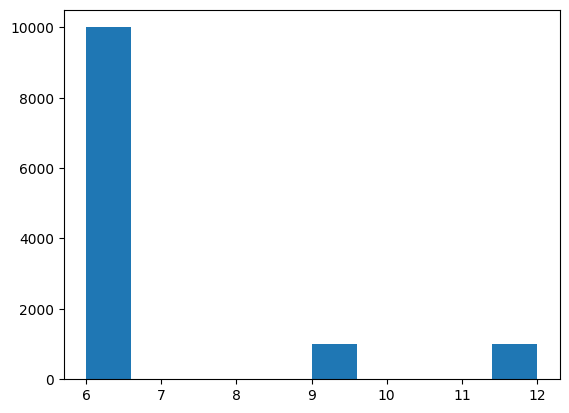

In [1234]:
plt.hist(water_data_silvan["N"])

In [1257]:
i = 0
Natoms = water_data_silvan["N"][i]
print(Natoms)
Natoms = 3
atoms = ase.Atoms(water_data_silvan["Z"][i][:Natoms], water_data_silvan["R"][i][:Natoms])
atoms

6


Atoms(symbols='HOH', pbc=False)

In [1258]:
from ase.visualize import view

view(atoms, viewer="x3d")

In [1268]:
distRs = np.linalg.norm(np.linalg.norm(water_data_silvan["R"][:,(0, 1)], axis=(2)), axis=1)

In [1267]:
water_data_silvan["Z"][0]

array([1, 8, 1, 1, 8, 1, 0, 0, 0, 0, 0, 0])

(array([5.800e+01, 1.699e+03, 3.506e+03, 5.010e+03, 8.340e+02, 3.830e+02,
        3.160e+02, 1.500e+02, 3.900e+01, 5.000e+00]),
 array([0.6855114 , 1.18993222, 1.69435303, 2.19877384, 2.70319465,
        3.20761546, 3.71203628, 4.21645709, 4.7208779 , 5.22529871,
        5.72971952]),
 <BarContainer object of 10 artists>)

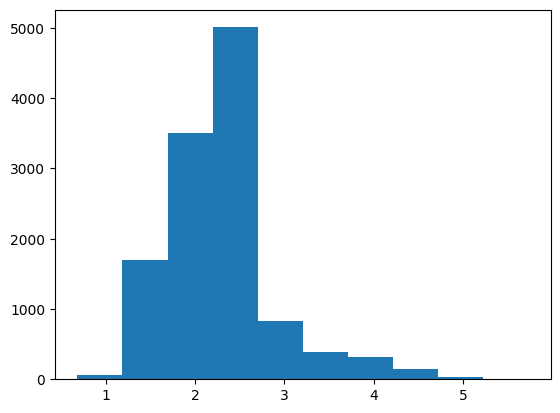

In [1269]:
plt.hist(distRs)

['_TemporaryMoleContext',
 '__add__',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattr__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_add_suffix',
 '_atm',
 '_atom',
 '_bas',
 '_basis',
 '_build_symmetry',
 '_built',
 '_ctx_lock',
 '_ecp',
 '_ecpbas',
 '_enuc',
 '_env',
 '_keys',
 '_libcint_ctr_coeff',
 '_nao',
 '_nelectron',
 '_pseudo',
 '_symm_axes',
 '_symm_orig',
 'ao2mo',
 'ao_labels',
 'ao_loc',
 'ao_loc_2c',
 'ao_loc_nr',
 'ao_rotation_matrix',
 'aoslice_2c_by_atom',
 'aoslice_by_atom',
 'aoslice_nr_by_atom',
 'apply',
 'atom',
 'atom_charge',
 'atom_charges',
 'atom_coord',
 'atom_coords',
 'atom_mass_list',
 'atom_nelec_core',
 'atom_nshells',

[0. 0. 0.]
converged SCF energy = -74.9516561746446
converged SCF energy = -74.9516561746453
Dipole moment(X, Y, Z, A.U.): -0.31170,  0.04042, -0.58072
--------------- DFRKS gradients ---------------
         x                y                z
0 H     2.4773564550     1.8476469982     0.9053096988
1 O    -1.8647276103    -0.0222608014    -3.0224428251
2 H    -0.6126315162    -1.8253812905     2.1171202961
----------------------------------------------


-74.95165617464528

In [1296]:
from tqdm import tqdm

In [1373]:
i = 0
Njobs = 10
start = 0 # next is from 500
dm0 = None
all_output = []
for i in tqdm(range(start, start+Njobs)):
    Natoms = water_data_silvan["N"][i]
    print(Natoms)
    Natoms = 3
    atoms = ase.Atoms(water_data_silvan["Z"][i][:Natoms], water_data_silvan["R"][i][:Natoms])
    atoms
    mol_from_ase = atoms_from_ase(atoms)
    mol = pyscf.M(
    atom=mol_from_ase,                         # water molecule
    basis="def2-tzvp",                # basis set
    spin=0,
    charge=0,
    unit="B",
    # output=log_file,              # save log file
    # verbose=verbose                          # control the level of print info
    )
    mol.set_common_orig([0, 0, 0])  # The gauge origin for dipole integral
    dir(mol)
    
    E = np.zeros(3)
    print(E)

    res_0, dm0 = maxwell_eval_ir_freq_intensity(E, mol, [dm0])
    # dm0 = None
    print(res_0["E"])
    all_output.append(res_0)
    print()
    
    output_res = [res_0]
    for i in range(2):
        E = np.random.normal(0, scale=0.01, size=(3,))
        print(E)
        res, dm0 = maxwell_eval_ir_freq_intensity(E, mol, [dm0])
        print(res["E"], 627.53* (res_0["E"] - res["E"]))

        all_output.append(res)

  0%|                                                                                                                                                                                        | 0/10 [00:00<?, ?it/s]

6
[0. 0. 0.]
converged SCF energy = -74.9516561746446
Dipole moment(X, Y, Z, A.U.): -0.31170,  0.04042, -0.58072
--------------- DFRKS gradients ---------------
         x                y                z
0 H     2.4773564621     1.8476470528     0.9053096169
1 O    -1.8647277701    -0.0222609046    -3.0224429108
2 H    -0.6126313635    -1.8253812419     2.1171204637
----------------------------------------------
-74.9516561746446

[-0.00988165  0.00923992 -0.00243428]
converged SCF energy = -74.7563777512731
Dipole moment(X, Y, Z, A.U.): -0.35213,  0.07990, -0.58193
--------------- DFRKS gradients ---------------
         x                y                z
0 H     2.4815137421     1.8397580642     0.9042760762
1 O    -1.8758650645    -0.0115078504    -3.0171583733
2 H    -0.6056512828    -1.8282453049     2.1128694721
----------------------------------------------
-74.7563777512731 -122.54306901831163
[-0.00248818  0.01014634 -0.00717327]
converged SCF energy = -74.7936467704871
Dip

 10%|█████████████████▌                                                                                                                                                              | 1/10 [00:35<05:15, 35.08s/it]

-74.79364677048707 -99.1556413909717
6
[0. 0. 0.]
converged SCF energy = -74.9620835424688
Dipole moment(X, Y, Z, A.U.):  0.64670, -0.09977, -0.07214
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -2.0575711786    -1.5458333068    -1.1742636886
1 O     3.3688832765    -0.8005079756    -0.5873580447
2 H    -1.3113158621     2.3463407660     1.7616199949
----------------------------------------------
-74.96208354246882

[-0.01119237 -0.00509394  0.00638366]
converged SCF energy = -74.7266895374148
Dipole moment(X, Y, Z, A.U.):  0.61152, -0.12317, -0.04291
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -2.0559510587    -1.5438732127    -1.1802101085
1 O     3.3627902303    -0.8078240341    -0.5776880594
2 H    -1.3068430027     2.3516967082     1.7578964393
----------------------------------------------
-74.72668953741479 -147.71679999155737
[0.00312775 0.00296389 0.0004218 ]
converge

 20%|███████████████████████████████████▏                                                                                                                                            | 2/10 [01:09<04:39, 34.91s/it]

-75.03574381485208 46.22403072867007
6
[0. 0. 0.]
converged SCF energy = -74.9406146919114
Dipole moment(X, Y, Z, A.U.): -0.05294,  0.41059,  0.52783
--------------- DFRKS gradients ---------------
         x                y                z
0 H     2.1582142183    -1.9468182705    -0.5195895625
1 O    -0.1277293794     2.1634506365     2.9384102568
2 H    -2.0304861828    -0.2166164912    -2.4187995719
----------------------------------------------
-74.9406146919114

[-0.00198709  0.00089227  0.01134661]
converged SCF energy = -74.9235226625585
Dipole moment(X, Y, Z, A.U.): -0.06321,  0.40737,  0.56684
--------------- DFRKS gradients ---------------
         x                y                z
0 H     2.1577039412    -1.9445829772    -0.5244155147
1 O    -0.1311418040     2.1599968571     2.9451147248
2 H    -2.0265634769    -0.2153980098    -2.4206781369
----------------------------------------------
-74.9235226625585 -10.725761179831187
[-0.01153474 -0.00585236  0.003646  ]
converg

 30%|████████████████████████████████████████████████████▊                                                                                                                           | 3/10 [01:44<04:03, 34.85s/it]

-75.1769653627524 148.31713647284738
6
[0. 0. 0.]
converged SCF energy = -74.9759395666317
Dipole moment(X, Y, Z, A.U.):  0.57878, -0.20233, -0.28017
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -2.5339559112     0.4414992254    -1.3491065282
1 O     3.0069415649    -1.0795593286    -1.6199756817
2 H    -0.4729715863     0.6380526202     2.9690799821
----------------------------------------------
-74.9759395666317

[ 0.00316168  0.00514001 -0.00400456]
converged SCF energy = -74.984039974389
Dipole moment(X, Y, Z, A.U.):  0.59066, -0.17782, -0.29415
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -2.5354576739     0.4382541267    -1.3470060859
1 O     3.0094729174    -1.0725164830    -1.6222588151
2 H    -0.4740011257     0.6342549723     2.9692626223
----------------------------------------------
-74.98403997438896 5.083248879918773
[-0.0081756  -0.0095924  -0.00731733]
converged

 40%|██████████████████████████████████████████████████████████████████████▍                                                                                                         | 4/10 [02:19<03:28, 34.79s/it]

-74.91017878279422 -41.266864681531224
6
[0. 0. 0.]
converged SCF energy = -75.040154247132
Dipole moment(X, Y, Z, A.U.):  0.40466,  0.18164,  0.51265
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -2.1574204942    -2.0054620494     0.0844586169
1 O     2.1210176778     1.0166029811     2.5116745336
2 H     0.0364014687     0.9888545834    -2.5961294394
----------------------------------------------
-75.04015424713195

[-0.01059322 -0.00527992  0.00923213]
converged SCF energy = -74.7914557557786
Dipole moment(X, Y, Z, A.U.):  0.36592,  0.16996,  0.54466
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -2.1568487535    -2.0083176442     0.0785321027
1 O     2.1129436077     1.0197792689     2.5133148605
2 H     0.0439036810     0.9885338978    -2.5918432863
----------------------------------------------
-74.79145575577864 -156.06576427894214
[ 0.0093338  -0.00157362  0.00144126]
conv

 50%|████████████████████████████████████████████████████████████████████████████████████████                                                                                        | 5/10 [02:54<02:53, 34.76s/it]

-75.22678090710812 117.11382793484603
6
[0. 0. 0.]
converged SCF energy = -74.8229224297989
Dipole moment(X, Y, Z, A.U.): -0.15838,  0.32457,  0.56451
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -0.2236460901     1.0892113890    -2.9573657425
1 O    -0.9945820163     2.0953091903     3.2058887143
2 H     1.2182298589    -3.1845153719    -0.2485169600
----------------------------------------------
-74.82292242979888

[-0.02480333  0.00154013  0.00073658]
converged SCF energy = -75.0014953184905
Dipole moment(X, Y, Z, A.U.): -0.26341,  0.31806,  0.56334
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -0.2106193760     1.0890274963    -2.9577848392
1 O    -1.0191208782     2.0903248502     3.2050870737
2 H     1.2297420469    -3.1793473343    -0.2472964332
----------------------------------------------
-75.00149531849046 112.05984484062486
[ 0.00662636  0.00277064 -0.00474919]
conve

 60%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 6/10 [03:28<02:19, 34.76s/it]

-74.79805826589262 -15.603008776094295
6
[0. 0. 0.]
converged SCF energy = -75.026853792554
Dipole moment(X, Y, Z, A.U.):  0.05705,  0.55167, -0.36831
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -0.4357378621    -2.7685261138    -1.0626283783
1 O     0.3121137585     2.9078133073    -1.7190293582
2 H     0.1236274430    -0.1392963226     2.7816559317
----------------------------------------------
-75.02685379255396

[ 0.00558122 -0.01191376 -0.01328334]
converged SCF energy = -74.9129351226752
Dipole moment(X, Y, Z, A.U.):  0.08542,  0.51242, -0.41191
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -0.4411175844    -2.7714573667    -1.0576959948
1 O     0.3217541128     2.9024895094    -1.7216580996
2 H     0.1193668940    -0.1310412602     2.7793522650
----------------------------------------------
-74.91293512267524 -71.48738290899846
[ 0.00274825 -0.00306057  0.00685932]
conve

 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                    | 7/10 [04:03<01:44, 34.78s/it]

-75.01132349955176 -9.745724767670769
6
[0. 0. 0.]
converged SCF energy = -74.975162926539
Dipole moment(X, Y, Z, A.U.):  0.64283,  0.03067, -0.17929
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -1.9255115544    -1.7559338026    -0.9911073005
1 O     3.3475308546    -0.1101597018    -1.1814572120
2 H    -1.4220151684     1.8660879998     2.1725663890
----------------------------------------------
-74.97516292653904

[-0.00129952  0.00434658 -0.0136463 ]
converged SCF energy = -75.1933025253844
Dipole moment(X, Y, Z, A.U.):  0.63398,  0.05575, -0.23489
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -1.9267157725    -1.7598007523    -0.9852272712
1 O     3.3465193565    -0.1024016074    -1.1926650685
2 H    -1.4197994455     1.8621968277     2.1778941566
----------------------------------------------
-75.19330252538444 136.88914246345206
[ 0.02041685  0.00398019 -0.00967126]
conver

 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                   | 8/10 [04:38<01:09, 34.81s/it]

-75.21355068183372 149.59546808007138
6
[0. 0. 0.]
converged SCF energy = -74.8851691680914
Dipole moment(X, Y, Z, A.U.):  0.52080, -0.38435, -0.17450
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -0.5761112017     3.0720050237    -0.9949552391
1 O     2.8725207916    -2.3187041289    -0.8732618310
2 H    -2.2964128521    -0.7532979818     1.8682165687
----------------------------------------------
-74.88516916809144

[ 0.0002059  -0.01008946  0.00868871]
converged SCF energy = -74.810799392799
Dipole moment(X, Y, Z, A.U.):  0.52337, -0.41453, -0.14342
--------------- DFRKS gradients ---------------
         x                y                z
0 H    -0.5736578714     3.0696253604    -0.9984327273
1 O     2.8739515985    -2.3208623029    -0.8675695618
2 H    -2.3002969782    -0.7487602351     1.8660018526
----------------------------------------------
-74.810799392799 -46.66926508926427
[0.00396965 0.00194806 0.00119966]
converged S

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                 | 9/10 [05:13<00:34, 34.78s/it]

-74.84356936554735 -26.105124090489184
6
[0. 0. 0.]
converged SCF energy = -74.9703729088424
Dipole moment(X, Y, Z, A.U.): -0.56338, -0.18799, -0.31191
--------------- DFRKS gradients ---------------
         x                y                z
0 H     1.9399291527     2.2194131471    -0.9134349212
1 O    -3.0220914372    -1.1030494039    -1.5535196675
2 H     1.0821489712    -1.1163640816     2.4669446664
----------------------------------------------
-74.97037290884236

[-0.00929782 -0.01924645 -0.00568868]
converged SCF energy = -75.3355955933562
Dipole moment(X, Y, Z, A.U.): -0.58429, -0.25851, -0.33644
--------------- DFRKS gradients ---------------
         x                y                z
0 H     1.9394671085     2.2238469968    -0.9099012019
1 O    -3.0258185517    -1.1156900653    -1.5598710746
2 H     1.0863382095    -1.1081574770     2.4697625021
----------------------------------------------
-75.33559559335617 229.18819121295132
[0.0120411  0.00500675 0.00583909]
converg

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [05:47<00:00, 34.80s/it]

-74.67975743927732 -182.36992561614957


In [1374]:
len(all_output)
# all_output[1]

30

In [1375]:
import pickle
# Save to file
with open('data4.pkl', 'wb') as f:
    pickle.dump(all_output, f)

In [1377]:
import pandas as pd

loaded_data = pd.read_pickle("data4.pkl")
loaded_data[0]

{'Ef': array([0., 0., 0.]),
 'D': array([-0.31170152,  0.04041616, -0.58072338]),
 'E': -74.9516561746446,
 'A': array([[ 3.69461622, -0.56809703, -0.37789706],
        [-0.56809703,  3.77866561,  0.33060785],
        [-0.37789706,  0.33060785,  3.33119099]]),
 'F': array([[-2.47735646, -1.84764705, -0.90530962],
        [ 1.86472777,  0.0222609 ,  3.02244291],
        [ 0.61263136,  1.82538124, -2.11712046]]),
 'H': array([[[[ 6.15406335,  7.02310466,  3.63673462],
          [ 7.02310466,  1.84953924,  2.57777879],
          [ 3.63673462,  2.57777879, -1.82263482]],
 
         [[-6.17347955, -7.01253136, -3.56975085],
          [-6.88942905, -1.83116538, -2.51173975],
          [-3.78031627, -2.71377555,  1.74832137]],
 
         [[ 0.01941025, -0.01057455, -0.06698416],
          [-0.13366817, -0.01837796, -0.06605775],
          [ 0.14358167,  0.1359749 ,  0.07431132]]],
 
 
        [[[-6.17347955, -6.88942905, -3.78031627],
          [-7.01253136, -1.83116538, -2.71377555],
       

In [1378]:
A.mean(axis=(0))

array([[ 3.69798303, -0.56889855, -0.37841755],
       [-0.56889855,  3.78299438,  0.33158006],
       [-0.37841755,  0.33158006,  3.33659796]])

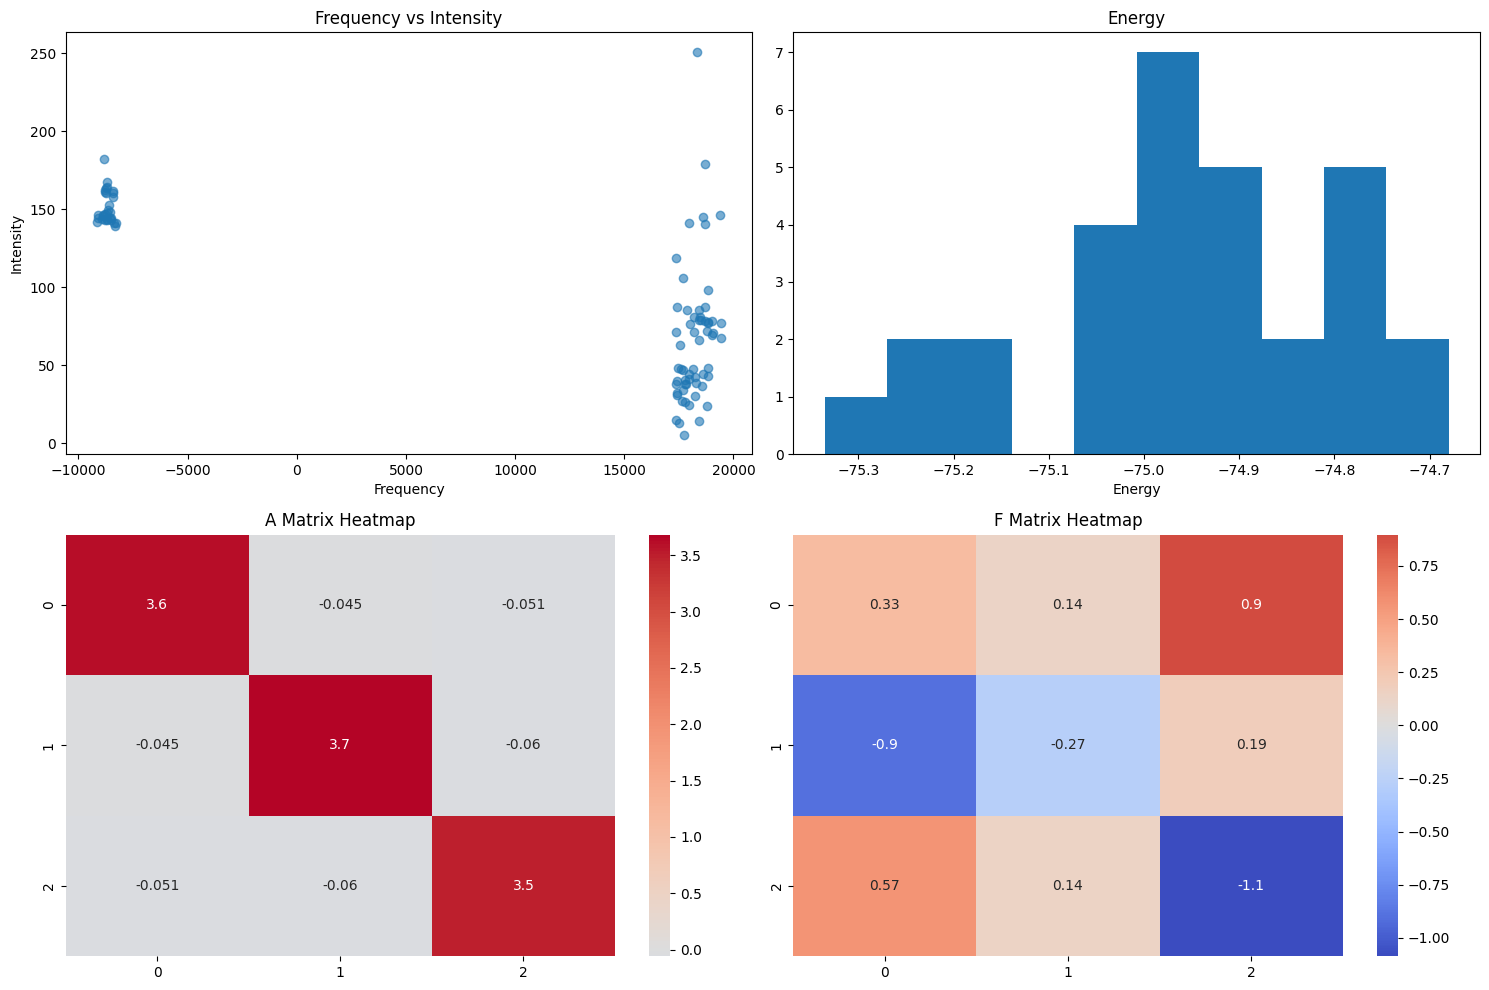

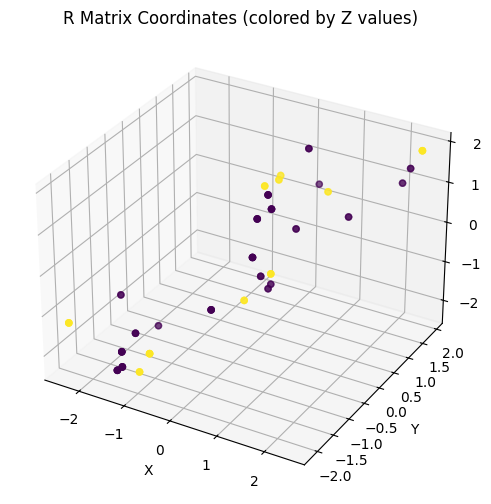

In [1385]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

data = loaded_data

# data = pd.read_csv('data.csv')
def _unpack(a, k):
    return np.array([_[k].get() if (not type(_[k]) == np.ndarray) and (not type(_[k]) is np.float64)  else _[k] for _ in a])

freq = _unpack(data, 'freq')
intensity = _unpack(data, 'intensity')
A = _unpack(data, 'A')
E = _unpack(data, 'E')
F = _unpack(data, 'F')
R = _unpack(data, 'R')
Z = _unpack(data, 'Z')


# Create figure with multiple subplots
# plt.style.use('seaborn')
fig = plt.figure(figsize=(15, 10))

# 1. Plot frequencies vs intensities
ax1 = plt.subplot(221)
plt.scatter(freq, intensity, alpha=0.6)
plt.xlabel('Frequency')
plt.ylabel('Intensity')
plt.title('Frequency vs Intensity')

# # 2. Plot 
ax2 = plt.subplot(222)
# eigenvals = [np.diag(_) for _ in A]
plt.hist(E)
plt.xlabel('Energy')
plt.ylabel('')
plt.title('Energy')

# 3. Create heatmap of A matrix
ax3 = plt.subplot(223)
sns.heatmap(A.mean(axis=0), annot=True, cmap='coolwarm', center=0)
plt.title('A Matrix Heatmap')

# 4. Create heatmap of F matrix
ax4 = plt.subplot(224)
sns.heatmap(F.mean(axis=0), annot=True, cmap='coolwarm', center=0)
plt.title('F Matrix Heatmap')

plt.tight_layout()
plt.show()

# Additional plot for R matrix coordinates
plt.figure(figsize=(8, 6))
ax = plt.axes(projection='3d')
ax.scatter(R[:, 0], R[:, 1], R[:, 2], c=Z, cmap='viridis')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.title('R Matrix Coordinates (colored by Z values)')
plt.show()

In [1329]:
all_output[0]["R"], all_output[0]["F"], all_output[0]["Ef"]

(array([[-1.9449275, -0.020043 , -1.2845885],
        [-1.2164175,  0.513377 , -1.0014085],
        [-1.0238475,  1.127237 , -1.7354585]]),
 array([[-2.47735646, -1.84764705, -0.90530962],
        [ 1.86472777,  0.0222609 ,  3.02244291],
        [ 0.61263136,  1.82538124, -2.11712046]]),
 array([0., 0., 0.]))

In [1330]:
all_output[1]["R"], all_output[1]["F"], all_output[1]["Ef"]

(array([[-1.9449275, -0.020043 , -1.2845885],
        [-1.2164175,  0.513377 , -1.0014085],
        [-1.0238475,  1.127237 , -1.7354585]]),
 array([[-2.47579734, -1.8510472 , -0.90111159],
        [ 1.86479647,  0.02729259,  3.0220366 ],
        [ 0.61100362,  1.8237498 , -2.12091217]]),
 array([-0.00514427, -0.01117406,  0.00406142]))

In [1333]:
all_output[2]["R"], all_output[2]["F"], all_output[2]["Ef"]

(array([[-1.9449275, -0.020043 , -1.2845885],
        [-1.2164175,  0.513377 , -1.0014085],
        [-1.0238475,  1.127237 , -1.7354585]]),
 array([[-2.48670070e+00, -1.83593402e+00, -9.02172062e-01],
        [ 1.88191809e+00,  1.63214290e-03,  3.00980948e+00],
        [ 6.04785112e-01,  1.83429686e+00, -2.10762459e+00]]),
 array([-0.00925975,  0.01989021,  0.00564881]))

In [1334]:
for _ in all_output[0].keys():
    print(_, all_output[0][_])

Ef [0. 0. 0.]
D [-0.31170152  0.04041616 -0.58072338]
E -74.9516561746446
A [[ 3.69461622 -0.56809703 -0.37789706]
 [-0.56809703  3.77866561  0.33060785]
 [-0.37789706  0.33060785  3.33119099]]
F [[-2.47735646 -1.84764705 -0.90530962]
 [ 1.86472777  0.0222609   3.02244291]
 [ 0.61263136  1.82538124 -2.11712046]]
H [[[[ 6.15406335  7.02310466  3.63673462]
   [ 7.02310466  1.84953924  2.57777879]
   [ 3.63673462  2.57777879 -1.82263482]]

  [[-6.17347955 -7.01253136 -3.56975085]
   [-6.88942905 -1.83116538 -2.51173975]
   [-3.78031627 -2.71377555  1.74832137]]

  [[ 0.01941025 -0.01057455 -0.06698416]
   [-0.13366817 -0.01837796 -0.06605775]
   [ 0.14358167  0.1359749   0.07431132]]]


 [[[-6.17347955 -6.88942905 -3.78031627]
   [-7.01253136 -1.83116538 -2.71377555]
   [-3.56975085 -2.51173975  1.74832137]]

  [[ 3.98496029  8.76448693  1.64502701]
   [ 8.76448693  4.6006612  -4.01017555]
   [ 1.64502701 -4.01017555  3.40735961]]

  [[ 2.18716974 -1.87505599  2.13536276]
   [-1.75195863 

In [1332]:
# E = -np.ones(3)
# print(E)
# res = maxwell_eval_ir_freq_intensity(E, mol)
# res

In [1335]:
for _ in res.keys():
    print(_, res[_].shape)
    print(res[_])

Ef (3,)
[ 0.00813606  0.00629756 -0.00287366]
D (3,)
[-0.28418409  0.05862333 -0.59138627]
E ()
-74.99002002439086
A (3, 3)
[[ 3.69189496 -0.58277156 -0.38466669]
 [-0.58277156  3.78366919  0.31123748]
 [-0.38466669  0.31123748  3.33817143]]
F (3, 3)
[[-2.47728253 -1.84731451 -0.90911753]
 [ 1.86082143  0.02141534  3.02413612]
 [ 0.61646374  1.82589418 -2.11500577]]
H (3, 3, 3, 3)
[[[[ 6.13902724  7.01656528  3.63896525]
   [ 7.01656528  1.83746456  2.5799723 ]
   [ 3.63896525  2.5799723  -1.82832037]]

  [[-6.15670493 -7.00475353 -3.57204238]
   [-6.88269384 -1.8179802  -2.51471225]
   [-3.78170997 -2.71591313  1.75508324]]

  [[ 0.01767187 -0.01181291 -0.06692333]
   [-0.13386377 -0.01948819 -0.06527873]
   [ 0.1427445   0.1359189   0.07323487]]]


 [[[-6.15670493 -6.88269384 -3.78170997]
   [-7.00475353 -1.8179802  -2.71591313]
   [-3.57204238 -2.51471225  1.75508324]]

  [[ 3.97008082  8.75802861  1.64258735]
   [ 8.75802861  4.59061798 -4.00533756]
   [ 1.64258735 -4.00533756  3.3

In [1137]:
1/1.62452981

0.6155627270391547

In [1138]:
ans = np.array(out_p) / dE /np.pi
ans

array([-0.04845763,  0.62178304, -0.29681203])

In [1149]:
ans / mf.dip_moment(unit="AU") #/ ase.units.Debye * ase.units.Bohr

Dipole moment(X, Y, Z, A.U.): -0.04685,  0.60123, -0.28700


array([1.0342078 , 1.03419348, 1.03420275])

In [924]:
[-0.5 * _ / dE for _ in out_alpha]

[array([ 4.50196119,  0.0920895 , -0.03994214]),
 array([0.09209103, 3.10104491, 0.03817404]),
 array([-0.03994255,  0.03816993,  3.16212412])]

In [880]:
# mol.intor('cint1e_r_sph', comp=3).sum()

In [705]:
# mf.mo_energy.sum() 

In [535]:
mf.mo_energy.sum() #* ase.units.Hartree

array(134.80098689)

In [558]:
polar, h1 = eval_polarizability(mf)

(43, 43)
[ -8.82859683 -12.44563097 -17.61462416 -20.98436119 -21.94619891
  -6.62252182  -8.06788231  -4.7738041   -7.74884255 -13.62417468
  -5.06725107  -4.65454145 -15.20379421  -5.31097181  -5.91440117
  -5.03229879  -7.70210387  -5.5807025   -5.14708083  -5.78252694
  -4.74732013  -9.38112545  -4.43287     -1.96492472  -2.58505485
  -4.05717321  -6.59440273  -3.79614409  -4.20507076  -3.25425193
  -2.55019082 -15.79832286 -25.81502627 -23.18707459  -7.560056
   6.13503223  -4.38432477  -9.89206399 -14.22023695 -16.05217521
  -4.23482691  -5.41045093  -8.03715352]
(43, 43)
[11.21957383 16.13861789 24.9192189  31.96585258 36.02858719 11.63845598
 12.03675993  7.17275667 16.63093111 22.27847041  8.27235932 14.14042196
 26.97964734  8.3286653   9.27319184  6.72782132  9.49074816  8.0604904
  7.45011266 12.08165157  7.26050006 10.96263485  7.45403916  2.87866934
  5.26013357  6.57673506  9.45061544  3.4164907   6.13660463  4.20297729
  3.08437854 26.67578997 43.99898666 40.5453402  17

In [560]:
h1.sum(axis=(1,2))

array([-364.07751861,  590.46629827,  444.74947188])

In [530]:
mf.dip_moment(unit="B") @ (1/polar)

array([-19.61635525,   0.13620998,  -0.46024868])

In [549]:
np.linalg.norm ( np.linalg.norm(mf.dip_moment(unit="B")) * (1/polar))

38.43564619233012

In [521]:
mf.dip_moment() * ase.units.Debye / ase.units.Bohr

array([-0.05727562,  0.73493739, -0.35082401])

In [455]:
_ = -h1.sum(axis=(1,2))
_.sum()

array(-672.50202177)

In [456]:
file_path = Path("~/mmml/tests/functionality/esp")
data_path = file_path / "water.xyz.npz"
data = pd.read_pickle(data_path)

In [489]:
# data["energy"] / ase.units.Hartree

In [458]:
data.keys()

dict_keys(['mol', 'calcs', 'opt_callback', 'energy', 'esp', 'esp_out', 'sorted_idxs', 'grid_indices', 'esp_grid', 'mol_coords_angstrom', 'mol_z', 'dipole', 'quadrupole', 'density', 'grid_dens', 'grid_esp', 'esp_indices', 'gradient', 'shielding', 'polarizability'])

In [473]:
alpha  = data["polarizability"] * (ase.units.Bohr)**3
alpha 

array([[ 0.77669076, -0.01250175,  0.004772  ],
       [-0.01250175,  1.00347174,  0.07983046],
       [ 0.004772  ,  0.07983046,  1.13278616]])

In [474]:
np.ones(3)

array([1., 1., 1.])

In [475]:
p = data["dipole"] * ase.units.Debye #/ ase.units.Bohr
p

array([-0.03030896,  0.38891212, -0.18564807])

In [476]:
p_norm = np.linalg.norm(p)
p_norm

0.4320144391345648

In [477]:
np.trace(p_norm / alpha)

1.368117636923897

In [546]:
np.linalg.norm(p_norm / alpha) 

137.25620056910512

In [742]:
mf, mol = setup_mol(mol_str, "def2-tzvp", "PBE0", 0, 0)
mf.kernel()
mf.get_veff().shape

overwrite output file: ./pyscf.log


(43, 43)

In [743]:
mf.scf_summary

{'e1': -123.09737703248709,
 'coul': 46.78612547475179,
 'exc': -9.26103719528753,
 'nuc': 9.194951725785334}

In [481]:
mf.scf_summary["exc"] + mf.scf_summary["nuc"]

-0.023363551998356158

In [550]:
mf.scf_summary["coul"] - mf.scf_summary["nuc"] #+ mf.scf_summary["exc"]

37.59116819491817

In [483]:
mf.scf_summary["e1"] - mf.scf_summary["exc"] + mf.scf_summary["nuc"]

-104.67245845989044

In [484]:
mf.scf_summary["e1"] + mf.scf_summary["exc"] + mf.scf_summary["coul"] + mf.scf_summary["nuc"]

-76.37718438355935

In [485]:
mf.scf_summary["e1"] + mf.scf_summary["exc"] + mf.scf_summary["nuc"]

-123.20444705805099

In [486]:
mf.dip_moment()

array([-0.14604   ,  1.8710922 , -0.88329239])

In [336]:
mf.e_tot

-76.3773370272375

In [303]:
mf.mo_energy.sum()

array(134.80099425)

In [306]:
-mf.mo_energy.sum(), (p/alpha).sum() 

(array(-134.80099425), -19.94039366769672)

In [5]:
esp = data["esp"]
esp.shape

(1910,)

In [285]:
sum_aux_basis = np.array([ 0.00010188, -0.0013073,   0.00062407])
sum_aux_basis.sum()

-0.00058135

In [6]:
esp_out = data["esp_out"]
esp_out.shape

(1748,)

In [7]:
sorted_idxs = data["sorted_idxs"]
sorted_idxs.shape, sorted_idxs.max()

((1748,), 1909)

In [8]:
esp[sorted_idxs]

array([-0.26873364, -0.26673155, -0.26549337, ...,  0.20839602,
        0.20840397,  0.20873471])

In [9]:
esp_grid = data["grid_esp"]
esp_grid.shape

(1910, 3)

In [10]:
esp_grid[sorted_idxs]

array([[-4.70087061,  7.12184458,  0.41306187],
       [-4.41829593,  9.31087399,  5.01882443],
       [-3.75054797,  7.4125607 ,  7.13880695],
       ...,
       [-6.58195244,  5.68231386,  1.28907577],
       [-4.67781416,  7.86950147,  1.37822277],
       [-6.31610085,  7.73455195,  2.55889625]])

In [11]:
dens = data["density"].get()
dens.shape

(97792,)

In [12]:
grid_dens = data["grid_dens"]
grid_dens.shape

(97792, 3)

In [13]:
esp_idxs = data["esp_indices"]
esp_idxs.shape

(1748,)

In [14]:
grid_dens[esp_idxs].shape

(1748, 3)

In [15]:
esp_idxs.max()

97565

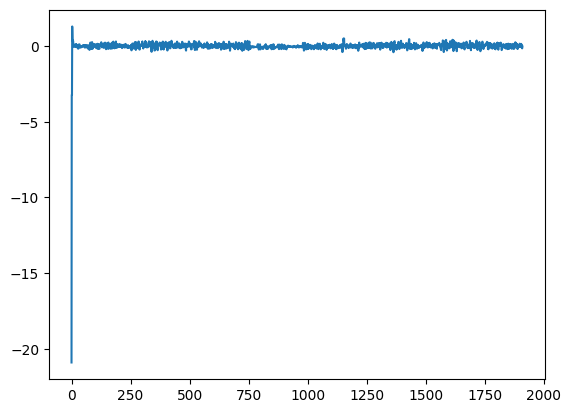

In [16]:
_ = plt.plot(esp)

(-0.1, 0.1)

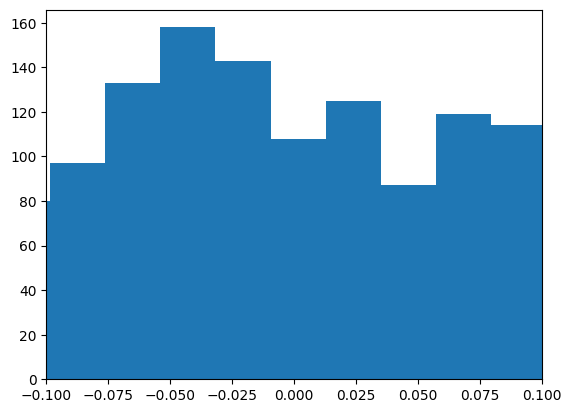

In [17]:
_ = plt.hist(esp, bins=1000)
plt.xlim(-0.1, 0.1)

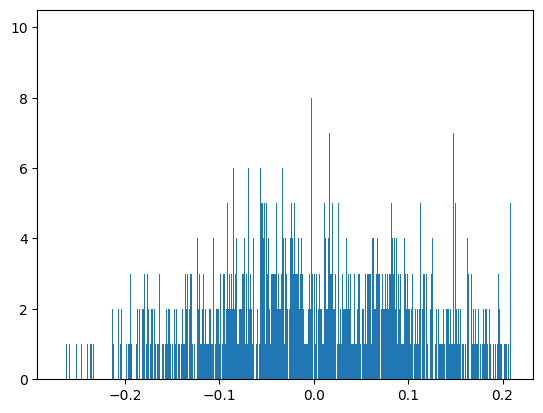

In [18]:
_ = plt.hist(esp_out, bins=1000)

In [1115]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.colors import Normalize

def plot_3d_scatter_views(coords, color_values, cmap_name='bwr', angles=[(20, 45), (70, -90), (20, 0)], vmin=None, vmax=None, s=1):
    """
    Plots a 3D scatter plot from coords and color_values, shown from 3 different angles.
    
    Parameters:
    - coords: (n, 3) array of xyz coordinates
    - color_values: (n,) array of scalar values used for colormap
    - cmap_name: string, name of matplotlib colormap
    - angles: list of (elev, azim) tuples for different 3D views
    """
    assert coords.shape[1] == 3, "Input coords must be of shape (n, 3)"
    assert coords.shape[0] == len(color_values), "color_values must have same length as number of points"
    if vmin is None:
        vmin = color_values.min()
    if vmax is None:
        vmax=color_values.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    mapped_colors = cmap(norm(color_values))

    fig = plt.figure(figsize=(18, 6))
    
    for i, (elev, azim) in enumerate(angles):
        ax = fig.add_subplot(2, 4, i + 1, projection='3d')
        ax.scatter(coords[:, 0], coords[:, 1], coords[:, 2],
                   c=mapped_colors, s=s, edgecolor='k', alpha=0.9)
        ax.view_init(elev=elev, azim=azim)
        ax.set_title(f"View {i+1} (elev={elev}, azim={azim})")
        ax.set_xlabel("X")
        ax.set_ylabel("Y")
        ax.set_zlabel("Z")
    

    # plot the distribution of esp values
    new_ax1 = fig.add_subplot(2, 4, 4)
    ax = plot_esp_distribution(color_values, cmap_name=cmap_name, vmin=vmin, vmax=vmax, ax=new_ax1)
    new_ax1.set_title("Distribution of ESP values")

    # Add shared colorbar
    mappable = cm.ScalarMappable(norm=norm, cmap=cmap)
    mappable.set_array(color_values)
    cbar = plt.colorbar(mappable, ax=fig.axes, orientation='horizontal', fraction=0.02, pad=0.4)
    cbar.set_label("ESP [(Hartree/Bohr) / $e$]")


    plt.tight_layout()
    plt.show()


def plot_esp_distribution(esp_values, cmap_name='bwr', vmin=None, vmax=None, ax=None):
    """
    Plots the distribution of ESP values using a histogram.
    
    Parameters:
    - esp_values: (n,) array of ESP values
    - cmap_name: string, name of matplotlib colormap
    - vmin: float, minimum value for color mapping
    - vmax: float, maximum value for color mapping
    - ax: matplotlib axis object, optional
    """
    if ax is None:
        ax = plt.gca()
    if vmin is None:
        vmin = esp_values.min()
    if vmax is None:
        vmax=esp_values.max()
    norm = Normalize(vmin=vmin, vmax=vmax)
    cmap = cm.get_cmap(cmap_name)
    mapped_colors = cmap(norm(esp_values))
    ax.hist(esp_values, bins=50, edgecolor='black')
    # set the color of the histogram bars to the mapped colors
    for i, bar in enumerate(ax.patches):
        bar.set_color(mapped_colors[i*len(esp_values)//50])
    # add mean, median, and std of esp values
    mean = np.mean(esp_values)
    median = np.median(esp_values)
    std = np.std(esp_values)

    ax.axvline(mean, color='red', linestyle='--', label=f'Mean {mean:.2f}')
    ax.axvline(median, color='green', linestyle='--', label=f'Median {median:.2f}')
    ax.axvline(std, color='blue', linestyle='--', label=f'Std {std:.2f}')
    ax.legend()
    ax.set_xlabel("ESP [(Hartree/Bohr) / $e$]")
    ax.set_ylabel("Frequency")
    ax.set_title("Distribution of ESP values")




    return ax



In [1116]:
esp.sum(), esp_out.sum()

(3.3144722545851923, 0.3034676838205854)

In [1117]:
esp.mean(), esp_out.mean()

(0.0017353257877409385, 0.00017360851477150196)

In [1118]:
np.median(esp), np.median(esp_out)

(0.006233426274140363, -0.004288673627481643)

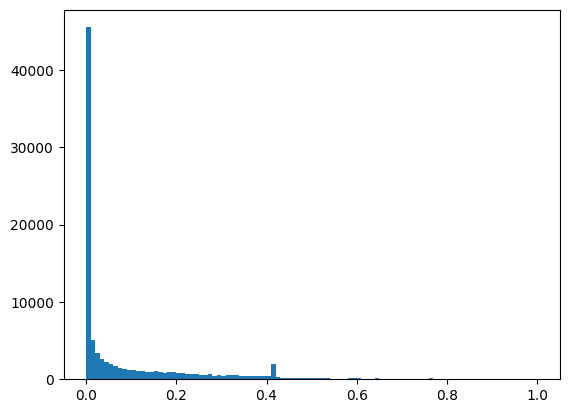

In [1119]:
_ = plt.hist(dens, bins=100, range=(0,1))

In [1129]:
dens.mean()

3.122944867687197

In [1121]:
esp_grid.shape, esp.shape

((1910, 3), (1910,))

In [1132]:
# plot_3d_scatter_views(grid_dens, dens,  vmin=0.0001, vmax=300, cmap_name="bwr", s=10)

/tmp/ipykernel_17786/1773329647.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_17786/1773329647.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_17786/1773329647.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


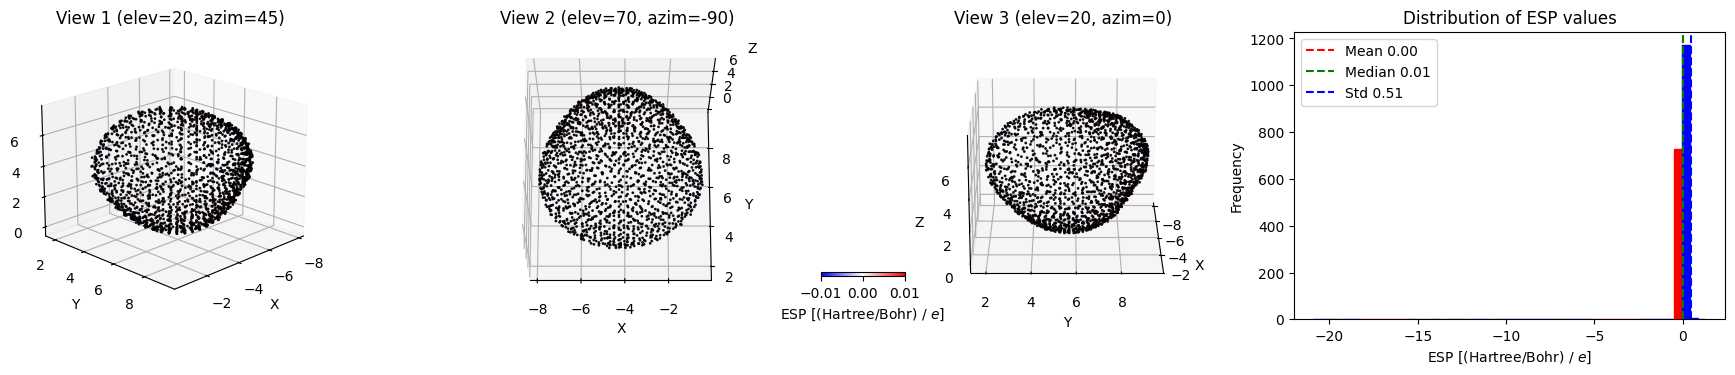

In [1123]:
plot_3d_scatter_views(esp_grid, esp,  vmin=-0.01, vmax=0.01, cmap_name="bwr")

/tmp/ipykernel_17786/1773329647.py:24: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_17786/1773329647.py:74: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(cmap_name)
/tmp/ipykernel_17786/1773329647.py:52: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


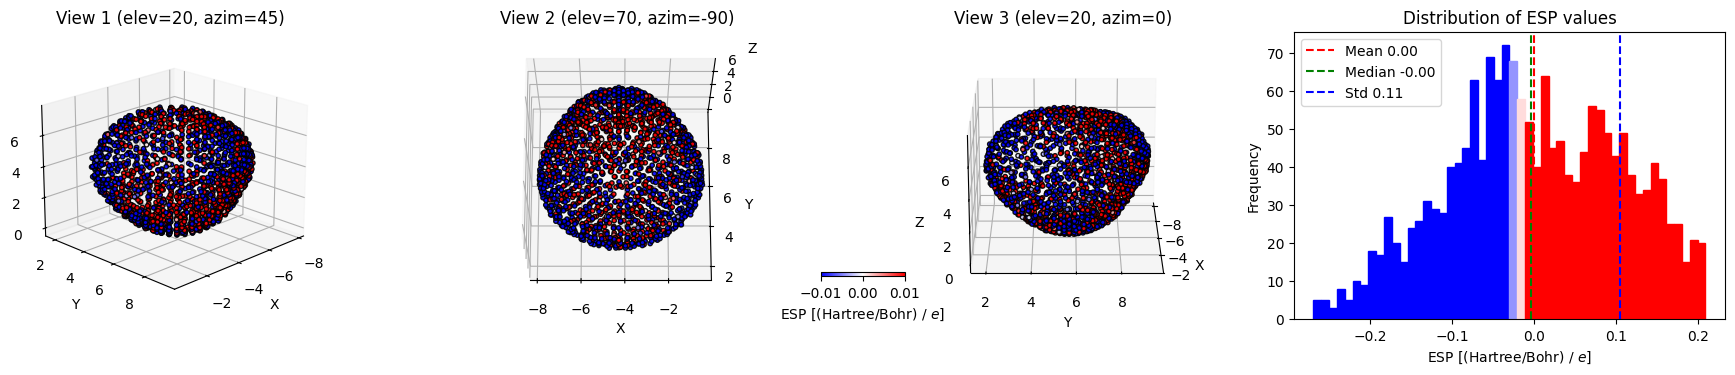

In [1125]:
plot_3d_scatter_views(esp_grid[sorted_idxs], esp_out, vmin=-0.01, vmax=0.01, cmap_name="bwr", s=10)

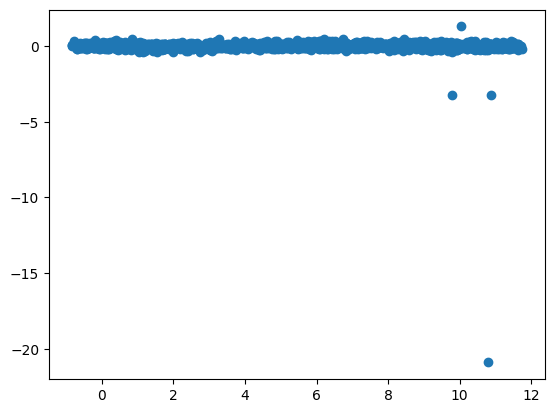

In [27]:
plt.scatter(esp_grid.sum(axis=1), esp)

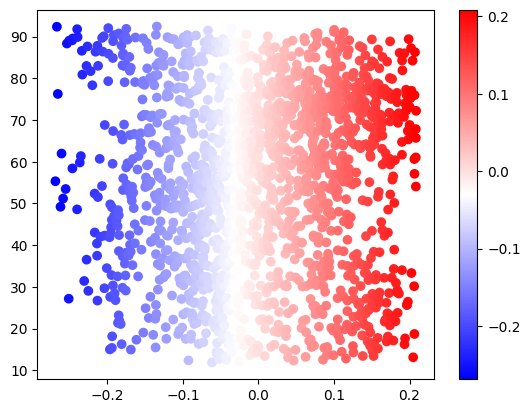

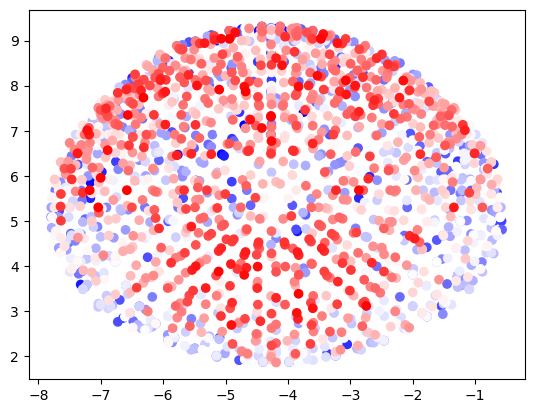

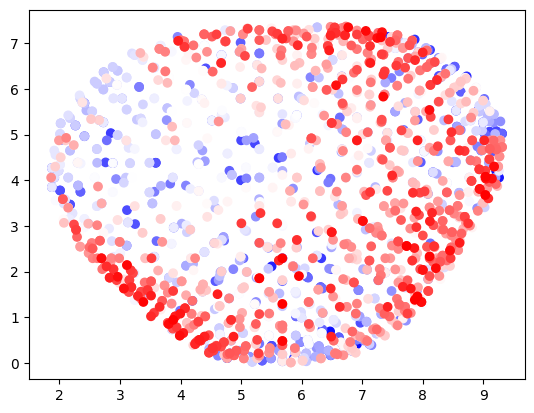

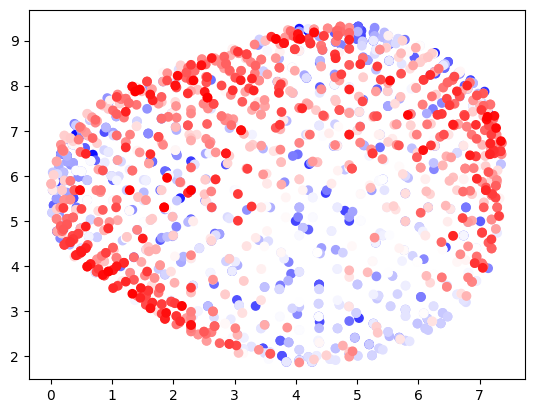

In [993]:
XR = np.linalg.norm(esp_grid[sorted_idxs]**2, axis=1)
s = plt.scatter(esp_out, XR,  c=esp_out, cmap="bwr")
plt.colorbar(s)
plt.show()
X,Y,Z = esp_grid[sorted_idxs].T
plt.scatter(X, Y,  c=esp_out, cmap="bwr", z_order=)
plt.show()
plt.scatter(Y, Z, c=esp_out, cmap="bwr")
plt.show()
plt.scatter(Z, Y, c=esp_out, cmap="bwr")

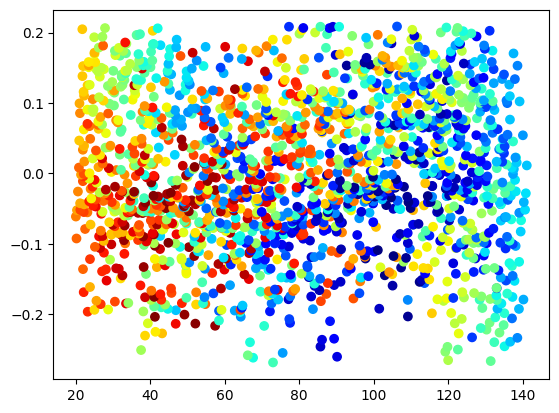

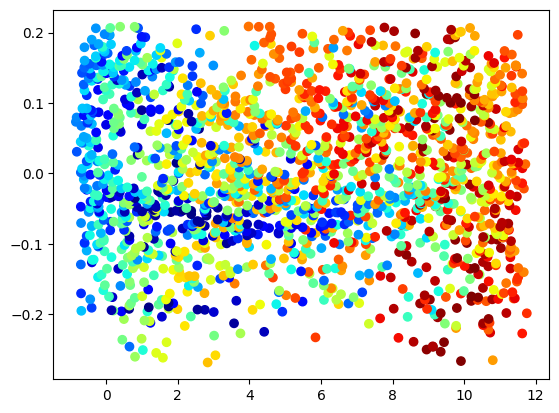

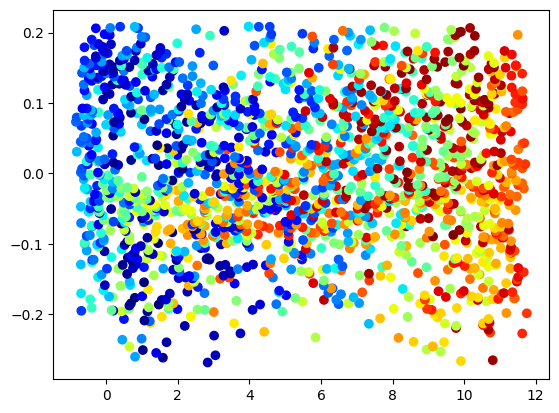